In [219]:

!pip install mwclient
!pip install transformers
!pip install yfinance
!pip install xgboost


In [259]:
import mwclient
import time

site= mwclient.Site('en.wikipedia.org')
page = site.pages["Bitcoin"]

In [260]:
revs = list(page.revisions())
revs[0]

OrderedDict([('revid', 1149274508),
             ('parentid', 1149262239),
             ('user', 'Jtbobwaysf'),
             ('timestamp',
              time.struct_time(tm_year=2023, tm_mon=4, tm_mday=11, tm_hour=6, tm_min=23, tm_sec=3, tm_wday=1, tm_yday=101, tm_isdst=-1)),
             ('comment', '/* Creation */ correct')])

In [261]:
revs = sorted(revs, key=lambda rev:rev['timestamp'])
revs[0]

OrderedDict([('revid', 275832581),
             ('parentid', 0),
             ('user', 'Pratyeka'),
             ('timestamp',
              time.struct_time(tm_year=2009, tm_mon=3, tm_mday=8, tm_hour=16, tm_min=41, tm_sec=7, tm_wday=6, tm_yday=67, tm_isdst=-1)),
             ('comment', 'creation (stub)')])

In [262]:
from transformers import pipeline
sentiment_pipeline = pipeline('sentiment-analysis')

def find_sentiment(text):
    sent = sentiment_pipeline([ text[:250]])[0]
    score = sent['score']
    if sent['label'] == 'NEGATIVE':
        score *= -1
    return score

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [264]:
edits = {}

for rev in revs:        
    date = time.strftime("%Y-%m-%d", rev["timestamp"])
    if date not in edits:
        edits[date] = dict(sentiments=list(), edit_count=0)
    
    edits[date]["edit_count"] += 1
    
    comment = rev.get("comment", "")
    edits[date]["sentiments"].append(find_sentiment(comment))

In [265]:
from statistics import mean

for key in edits:
    if len(edits[key]["sentiments"]) > 0:
        edits[key]["sentiment"] = mean(edits[key]["sentiments"])
        edits[key]["neg_sentiment"] = len([s for s in edits[key]["sentiments"] if s < 0]) / len(edits[key]["sentiments"])
    else:
        edits[key]["sentiment"] = 0
        edits[key]["neg_sentiment"] = 0
    
    del edits[key]["sentiments"]

In [266]:
import pandas as pd

edits_df = pd.DataFrame.from_dict(edits, orient='index')

In [267]:
edits_df.iloc[0]

edit_count       24.000000
sentiment        -0.500821
neg_sentiment     0.750000
Name: 2014-03-01, dtype: float64

In [268]:
edits_df.index = pd.to_datetime(edits_df.index)
first_date = edits_df.reset_index()
first_date = first_date.iloc[0]['index']
print(first_date)

2014-03-01 00:00:00


In [269]:
from datetime import datetime 

dates = pd.date_range(start=first_date, end=datetime.today())
dates

DatetimeIndex(['2014-03-01', '2014-03-02', '2014-03-03', '2014-03-04',
               '2014-03-05', '2014-03-06', '2014-03-07', '2014-03-08',
               '2014-03-09', '2014-03-10',
               ...
               '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12',
               '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16',
               '2023-04-17', '2023-04-18'],
              dtype='datetime64[ns]', length=3336, freq='D')

In [270]:
edits_df = edits_df.reindex(dates, fill_value=0)
edits_df.tail(20)

,edit_count,sentiment,neg_sentiment
2023-03-30,1,-0.997922,1.0
2023-03-31,0,0.000000,0.0
2023-04-01,0,0.000000,0.0
2023-04-02,0,0.000000,0.0
2023-04-03,1,-0.996604,1.0
2023-04-04,0,0.000000,0.0
2023-04-05,0,0.000000,0.0
2023-04-06,0,0.000000,0.0
2023-04-07,0,0.000000,0.0
2023-04-08,0,0.000000,0.0


In [271]:
rolling_edits = edits_df.rolling(15).mean()

In [272]:
rolling_edits

,edit_count,sentiment,neg_sentiment
2014-03-01,NaN,NaN,NaN
2014-03-02,NaN,NaN,NaN
2014-03-03,NaN,NaN,NaN
2014-03-04,NaN,NaN,NaN
2014-03-05,NaN,NaN,NaN
...,...,...,...
2023-04-14,0.200000,-0.066376,0.100000
2023-04-15,0.200000,-0.066376,0.100000
2023-04-16,0.200000,-0.066376,0.100000
2023-04-17,0.200000,-0.066376,0.100000


In [273]:
rolling_edits = rolling_edits.dropna()
rolling_edits

,edit_count,sentiment,neg_sentiment
2014-03-15,17.533333,-0.630024,0.811900
2014-03-16,16.000000,-0.663276,0.828567
2014-03-17,16.133333,-0.658119,0.825233
2014-03-18,16.600000,-0.710541,0.853567
2014-03-19,17.000000,-0.748134,0.873567
...,...,...,...
2023-04-14,0.200000,-0.066376,0.100000
2023-04-15,0.200000,-0.066376,0.100000
2023-04-16,0.200000,-0.066376,0.100000
2023-04-17,0.200000,-0.066376,0.100000


In [274]:
rolling_edits.to_csv('wikipedia_edits.csv')

In [275]:
import yfinance as yf
import os 

In [276]:
btc_ticker = yf.Ticker("BTC-USD")

In [277]:
btc = btc_ticker.history(period="max")

In [278]:
btc

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0
...,...,...,...,...,...,...,...
2023-04-14 00:00:00+00:00,30409.562500,31005.607422,30044.498047,30485.699219,22659995079,0.0,0.0
2023-04-15 00:00:00+00:00,30490.750000,30601.740234,30245.882812,30318.496094,11940685378,0.0,0.0
2023-04-16 00:00:00+00:00,30315.976562,30555.537109,30157.832031,30315.355469,12854816417,0.0,0.0


In [279]:
btc.index = pd.to_datetime(btc.index)
btc.index = btc.index.tz_localize(None) 
del btc['Dividends']
del btc['Stock Splits']
btc.columns = [c.lower() for c in btc.columns]


<Axes: xlabel='Date'>

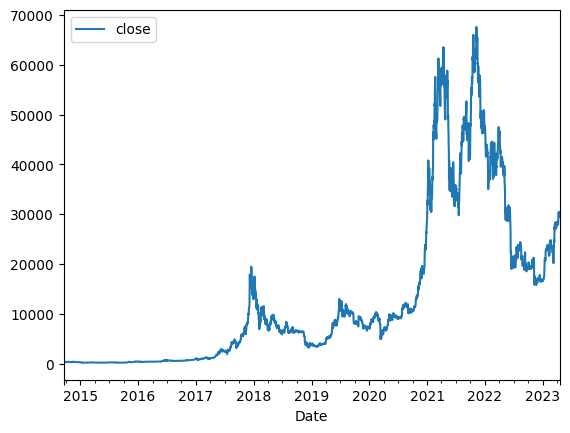

In [280]:
btc.plot.line(y='close', use_index=True)

In [281]:
wiki = pd.read_csv("wikipedia_edits.csv", index_col=0, parse_dates=True)
wiki

,edit_count,sentiment,neg_sentiment
2014-03-15,17.533333,-0.630024,0.811900
2014-03-16,16.000000,-0.663276,0.828567
2014-03-17,16.133333,-0.658119,0.825233
2014-03-18,16.600000,-0.710541,0.853567
2014-03-19,17.000000,-0.748134,0.873567
...,...,...,...
2023-04-14,0.200000,-0.066376,0.100000
2023-04-15,0.200000,-0.066376,0.100000
2023-04-16,0.200000,-0.066376,0.100000
2023-04-17,0.200000,-0.066376,0.100000


In [282]:
btc = btc.merge(wiki, left_index=True, right_index=True)
btc

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,3.600000,-0.210959,0.513422
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,3.266667,-0.263395,0.541993
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,3.466667,-0.228847,0.508660
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,3.400000,-0.208723,0.497549
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,3.333333,-0.195046,0.486438
...,...,...,...,...,...,...,...,...
2023-04-14,30409.562500,31005.607422,30044.498047,30485.699219,22659995079,0.200000,-0.066376,0.100000
2023-04-15,30490.750000,30601.740234,30245.882812,30318.496094,11940685378,0.200000,-0.066376,0.100000
2023-04-16,30315.976562,30555.537109,30157.832031,30315.355469,12854816417,0.200000,-0.066376,0.100000
2023-04-17,30317.146484,30319.197266,29275.371094,29445.044922,17872186762,0.200000,-0.066376,0.100000


In [283]:
btc["tomorrow"] = btc["close"].shift(-1)
btc

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,3.600000,-0.210959,0.513422,424.440002
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,3.266667,-0.263395,0.541993,394.795990
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,3.466667,-0.228847,0.508660,408.903992
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,3.400000,-0.208723,0.497549,398.821014
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,3.333333,-0.195046,0.486438,402.152008
...,...,...,...,...,...,...,...,...,...
2023-04-14,30409.562500,31005.607422,30044.498047,30485.699219,22659995079,0.200000,-0.066376,0.100000,30318.496094
2023-04-15,30490.750000,30601.740234,30245.882812,30318.496094,11940685378,0.200000,-0.066376,0.100000,30315.355469
2023-04-16,30315.976562,30555.537109,30157.832031,30315.355469,12854816417,0.200000,-0.066376,0.100000,29445.044922
2023-04-17,30317.146484,30319.197266,29275.371094,29445.044922,17872186762,0.200000,-0.066376,0.100000,30251.263672


In [284]:
btc["target"] = (btc["tomorrow"] > btc["close"]).astype(int)
btc["target"].value_counts()
btc

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow,target
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,3.600000,-0.210959,0.513422,424.440002,0
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,3.266667,-0.263395,0.541993,394.795990,0
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,3.466667,-0.228847,0.508660,408.903992,1
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,3.400000,-0.208723,0.497549,398.821014,0
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,3.333333,-0.195046,0.486438,402.152008,1
...,...,...,...,...,...,...,...,...,...,...
2023-04-14,30409.562500,31005.607422,30044.498047,30485.699219,22659995079,0.200000,-0.066376,0.100000,30318.496094,0
2023-04-15,30490.750000,30601.740234,30245.882812,30318.496094,11940685378,0.200000,-0.066376,0.100000,30315.355469,0
2023-04-16,30315.976562,30555.537109,30157.832031,30315.355469,12854816417,0.200000,-0.066376,0.100000,29445.044922,0
2023-04-17,30317.146484,30319.197266,29275.371094,29445.044922,17872186762,0.200000,-0.066376,0.100000,30251.263672,1


In [285]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)

train = btc.iloc[:-200]
test = btc.iloc[-200:]

predictors = ["close", "volume", "open", "high", "low", "edit_count", "sentiment", "neg_sentiment"]
model.fit(train[predictors], train["target"])

RandomForestClassifier(min_samples_split=50, random_state=1)

In [286]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["target"], preds)

0.509090909090909

In [287]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name='predictions')
    combined = pd.concat([test["target"], preds], axis=1)
    return combined

In [288]:
def backtest(data, model, predictors, start=1095, step=150):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)
    

In [289]:
import xgboost as xgb

model = xgb.XGBClassifier(random_state = 1, learning_rate=0.1, n_estimators=200)
predictions = backtest(btc, model, predictors)

In [290]:
precision_score(predictions['target'], predictions["predictions"])

0.5128205128205128

In [291]:
def compute_rolling(btc):
    horizons = [2,7,60,365]
    new_predictors = ["close", "sentiment", "neg_sentiment"]

    for horizon in horizons:
        rolling_averages = btc.rolling(horizon, min_periods=1).mean()

        ratio_column = f"close_ratio_{horizon}"
        btc[ratio_column] = btc["close"] / rolling_averages["close"]
        
        edit_column = f"edit_{horizon}"
        btc[edit_column] = rolling_averages["edit_count"]

        rolling = btc.rolling(horizon, closed='left', min_periods=1).mean()
        trend_column = f"trend_{horizon}"
        btc[trend_column] = rolling["target"]

        new_predictors+= [ratio_column, trend_column, edit_column]
    return btc, new_predictors


In [292]:
btc, new_predictors = compute_rolling(btc.copy())

In [293]:
btc

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow,target,...,trend_2,close_ratio_7,edit_7,trend_7,close_ratio_60,edit_60,trend_60,close_ratio_365,edit_365,trend_365
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,3.600000,-0.210959,0.513422,424.440002,0,...,NaN,1.000000,3.600000,NaN,1.000000,3.600000,NaN,1.000000,3.600000,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,3.266667,-0.263395,0.541993,394.795990,0,...,0.0,0.962696,3.433333,0.000000,0.962696,3.433333,0.000000,0.962696,3.433333,0.000000
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,3.466667,-0.228847,0.508660,408.903992,1,...,0.0,0.927789,3.444444,0.000000,0.927789,3.444444,0.000000,0.927789,3.444444,0.000000
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,3.400000,-0.208723,0.497549,398.821014,0,...,0.5,0.970419,3.433333,0.333333,0.970419,3.433333,0.333333,0.970419,3.433333,0.333333
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,3.333333,-0.195046,0.486438,402.152008,1,...,0.5,0.956729,3.413333,0.250000,0.956729,3.413333,0.250000,0.956729,3.413333,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-14,30409.562500,31005.607422,30044.498047,30485.699219,22659995079,0.200000,-0.066376,0.100000,30318.496094,0,...,1.0,1.029959,0.285714,0.857143,1.187580,0.565556,0.500000,1.319553,0.701553,0.471233
2023-04-15,30490.750000,30601.740234,30245.882812,30318.496094,11940685378,0.200000,-0.066376,0.100000,30315.355469,0,...,0.5,1.012722,0.276190,0.714286,1.174889,0.567778,0.483333,1.313911,0.701187,0.468493
2023-04-16,30315.976562,30555.537109,30157.832031,30315.355469,12854816417,0.200000,-0.066376,0.100000,29445.044922,0,...,0.0,1.003128,0.266667,0.571429,1.170227,0.570000,0.466667,1.315353,0.700822,0.468493
2023-04-17,30317.146484,30319.197266,29275.371094,29445.044922,17872186762,0.200000,-0.066376,0.100000,30251.263672,1,...,0.0,0.975289,0.257143,0.428571,1.132390,0.572222,0.466667,1.279153,0.700457,0.468493


In [294]:
predictions = backtest(btc, model, new_predictors)

In [295]:
precision_score(predictions['target'], predictions['predictions'])

0.5383867832847424

In [296]:
predictions

,target,predictions
2017-09-16,0,1
2017-09-17,1,1
2017-09-18,0,0
2017-09-19,0,1
2017-09-20,0,1
...,...,...
2023-04-14,0,0
2023-04-15,0,0
2023-04-16,0,0
2023-04-17,1,1


## To improve: 

- scrape news articles
- look at tweets
- google trends


- find other corralated informations (inflation rate, ETH, GDP growth rate)
- tune the model more